## 0.  Google Drive Amount

In [1]:
import os, sys 
from google.colab import drive 
drive.mount('/content/drive') 
nb_path = '/content/drive/My Drive/Colab Notebooks/novel_sentiment_analysis'

os.chdir(nb_path)
os.getcwd()

Mounted at /content/drive


'/content/drive/My Drive/Colab Notebooks/novel_sentiment_analysis'

## 1. Importing Library

In [2]:
import multiprocessing

from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser

import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing
# !python -m spacy download en
# !python -m spacy download en_core_web_sm

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)


# visualization
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import nltk
nltk.download('wordnet')
nltk.download('sentiwordnet')
from nltk.corpus import sentiwordnet as swn



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.


## 2. Loading Text File

In [3]:
file_path = 'a_tale_of_two_cities.txt'

text_data = []
with open(file_path) as f:
    while True:
        line = f.readline()
        if line == '\n': # delete new line mark
            continue
        line = line.replace('\n', '') # delete new line mark in end of each sentence
        if not line:
            break
        text_data.append(line)

print(text_data[:5])

['A TALE OF TWO CITIES', 'A STORY OF THE FRENCH REVOLUTION', 'By Charles Dickens', 'Book the First—Recalled to Life', 'CHAPTER I.']


## 3. Checking Text Data Frame

In [4]:
text_df = pd.DataFrame(text_data)
text_df.columns = ['sentence']
print("\n")
print("#"*60)
print("head of text data frame")
print(text_df.head(10))
print(text_df.tail(10))



############################################################
head of text data frame
                                            sentence
0                               A TALE OF TWO CITIES
1                   A STORY OF THE FRENCH REVOLUTION
2                                 By Charles Dickens
3                    Book the First—Recalled to Life
4                                         CHAPTER I.
5                                         The Period
6  It was the best of times, it was the worst of ...
7  There were a king with a large jaw and a queen...
8  It was the year of Our Lord one thousand seven...
9  France, less favoured on the whole as to matte...
                                               sentence
3373  She kisses his lips; he kisses hers; they sole...
3374  “I am the Resurrection and the Life, saith the...
3375  The murmuring of many voices, the upturning of...
3376  They said of him, about the city that night, t...
3377  One of the most remarkable sufferers by the 

## 4. Preprocessing Text Data

In [5]:
t = time()
print("\n")
print("#"*60)

print("loading spacy preprocessor...")

nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed
# nlp = spacy.load("en_core_web_sm")

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)


print("lower, remove special token...")
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in text_df['sentence'])

print("lemmatizing, removing stopwords, removing short sentence...")
txt = [cleaning(text_df) for text_df in nlp.pipe(brief_cleaning, batch_size=5000)]


text_df_clean = pd.DataFrame({'preprocessed_sentence': txt})
print("drop NA, drop duplicates...")
text_df_clean = text_df_clean.dropna().drop_duplicates()
print()
print(text_df_clean.shape)
print(text_df_clean.head(10))
print()


print()
print('Using Gensim Phrases package to automatically detect common phrases (bigrams) from a list of sentences...')
sentences = [row.split() for row in text_df_clean['preprocessed_sentence']]
bigram_model = Phrases(sentences, min_count=30, progress_per=10000)

print("example of bigram vocab")
list(bigram_model.vocab.keys())[:5]

print("change senteces using bigram...")
for i, sentence in enumerate(sentences):
    bigram_s = bigram_model[sentence]
    if sentence != bigram_s:
        sentences[i] = bigram_s
        #print(f'{i}\t', "--"*20)
        #print(f"raw    sentences: {sentence}")
        #print(f"Bigram sentences: {bigram_s}")
print()
print("example of preprocesed sentences")
for i in range(5):
    print(f"sentence {i}: \t", sentences[i])
print()


# word frequency check
"""
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
print(len(word_freq))
sorted(word_freq, key=word_freq.get, reverse=True)[:10]
"""

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))



############################################################
loading spacy preprocessor...
lower, remove special token...
lemmatizing, removing stopwords, removing short sentence...


INFO - 07:52:05: NumExpr defaulting to 2 threads.
INFO - 07:52:05: collecting all words and their counts
INFO - 07:52:05: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 07:52:05: collected 51774 word types from a corpus of 56455 words (unigram + bigrams) and 2945 sentences
INFO - 07:52:05: using 51774 counts as vocab in Phrases<0 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>


drop NA, drop duplicates...

(2945, 1)
                                preprocessed_sentence
1                             story french revolution
3                                    book recall life
6   good time bad time age wisdom age foolishness ...
7   king large jaw queen plain face throne england...
8   year lord thousand seven seventy spiritual rev...
9   france favour matter spiritual sister shield t...
10  england scarcely order protection justify nati...
11  thing thousand like come pass close dear old y...
14  dover road lie friday night late november pers...
15  droop head tremulous tail mash way thick mud f...


Using Gensim Phrases package to automatically detect common phrases (bigrams) from a list of sentences...
example of bigram vocab
change senteces using bigram...


/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")



example of preprocesed sentences
sentence 0: 	 ['story', 'french', 'revolution']
sentence 1: 	 ['book', 'recall', 'life']
sentence 2: 	 ['good', 'time', 'bad', 'time', 'age', 'wisdom', 'age', 'foolishness', 'epoch', 'belief', 'epoch', 'incredulity', 'season', 'light', 'season', 'darkness', 'spring', 'hope', 'winter', 'despair', 'go', 'direct', 'heaven', 'go', 'direct', 'way', 'short', 'period', 'far', 'like', 'present', 'period', 'noisiest', 'authority', 'insist', 'receive', 'good', 'evil', 'superlative', 'degree', 'comparison']
sentence 3: 	 ['king', 'large', 'jaw', 'queen', 'plain', 'face', 'throne', 'england', 'king', 'large', 'jaw', 'queen', 'fair', 'face', 'throne', 'france', 'country', 'clear', 'crystal', 'lord', 'state', 'preserve', 'loaf', 'fish', 'thing', 'general', 'settle']
sentence 4: 	 ['year', 'lord', 'thousand', 'seven', 'seventy', 'spiritual', 'revelation', 'concede', 'england', 'favour', 'period', 'mrs', 'southcott', 'recently', 'attain', 'twentieth', 'bless', 'birthd

## 5. Training Word2Vec Model

In [6]:
t = time()

print("\n")
print("#"*60)
print()
print("CPU check...")
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
print("the number of processor: ", cores)
print()

print("Define Word2Vec Model...")
size = 300
window = 2
print("the size of dimensions of each word vector: ", size)
print("the size of window: ", size)
w2v_model = Word2Vec(min_count=5,
                     window=window,
                     size=size,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

print()
print("buiding vocabulary...")
w2v_model.build_vocab(sentences, progress_per=10000)
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))
print()


t = time()
print("training Word2Vec model...")
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=1000, report_delay=1)
print("training is done...")
print()

print("saving trained word2vec model...")
file_path = './word2vec_model/a_tale_of_two_cites_w2v_model.model'
print("file path:\t", file_path)
w2v_model.save(file_path)
print()

print("loading saved word2vec model...")
w2v_model = Word2Vec.load(file_path)
print()

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))
print()

INFO - 07:52:06: collecting all words and their counts
INFO - 07:52:06: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 07:52:06: collected 7245 word types from a corpus of 55013 raw words and 2945 sentences
INFO - 07:52:06: Loading a fresh vocabulary
INFO - 07:52:06: effective_min_count=5 retains 2033 unique words (28% of original 7245, drops 5212)
INFO - 07:52:06: effective_min_count=5 leaves 46111 word corpus (83% of original 55013, drops 8902)
INFO - 07:52:06: deleting the raw counts dictionary of 7245 items
INFO - 07:52:06: sample=6e-05 downsamples 1300 most-common words
INFO - 07:52:06: downsampling leaves estimated 18601 word corpus (40.3% of prior 46111)
INFO - 07:52:06: estimated required memory for 2033 words and 300 dimensions: 5895700 bytes
INFO - 07:52:06: resetting layer weights




############################################################

CPU check...
the number of processor:  2

Define Word2Vec Model...
the size of dimensions of each word vector:  300
the size of window:  300

buiding vocabulary...


INFO - 07:52:06: training model with 1 workers on 2033 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 07:52:06: worker thread finished; awaiting finish of 0 more threads
INFO - 07:52:06: EPOCH - 1 : training on 55013 raw words (18537 effective words) took 0.2s, 113591 effective words/s


Time to build vocab: 0.01 mins

training Word2Vec model...


INFO - 07:52:07: worker thread finished; awaiting finish of 0 more threads
INFO - 07:52:07: EPOCH - 2 : training on 55013 raw words (18551 effective words) took 0.2s, 106128 effective words/s
INFO - 07:52:07: worker thread finished; awaiting finish of 0 more threads
INFO - 07:52:07: EPOCH - 3 : training on 55013 raw words (18620 effective words) took 0.2s, 120245 effective words/s
INFO - 07:52:07: worker thread finished; awaiting finish of 0 more threads
INFO - 07:52:07: EPOCH - 4 : training on 55013 raw words (18532 effective words) took 0.1s, 124294 effective words/s
INFO - 07:52:07: worker thread finished; awaiting finish of 0 more threads
INFO - 07:52:07: EPOCH - 5 : training on 55013 raw words (18634 effective words) took 0.2s, 118290 effective words/s
INFO - 07:52:07: worker thread finished; awaiting finish of 0 more threads
INFO - 07:52:07: EPOCH - 6 : training on 55013 raw words (18617 effective words) took 0.2s, 123305 effective words/s
INFO - 07:52:07: worker thread finished;

training is done...

saving trained word2vec model...
file path:	 ./word2vec_model/a_tale_of_two_cites_w2v_model.model

loading saved word2vec model...

Time to train the model: 2.61 mins



## 6. Word Embedding

In [7]:
print("\n")
print("#"*60)
print("checking word embeddings...")

word_vectors = w2v_model.wv
print("total number of words: ", len(word_vectors.index2word))
print()
print("5 example of word vectors")
for i in range(5):
    word = word_vectors.index2word[i]
    print(f"[{i+1}]: \t", word)
    print(word_vectors.get_vector(word))



############################################################
checking word embeddings...
total number of words:  2033

5 example of word vectors
[1]: 	 say
[-6.29369855e-01 -8.31537619e-02 -7.54611194e-02 -5.91045439e-01
  4.12274122e-01  4.36406016e-01 -4.25225765e-01 -2.92339087e-01
 -1.15563318e-01 -1.49063513e-01 -1.38166815e-01 -1.46484658e-01
  3.42151582e-01  2.97723293e-01 -3.54425907e-01  1.50363808e-02
 -2.36386776e-01  2.58438379e-01  7.17831850e-02  5.72421737e-02
  3.91747683e-01 -3.76389712e-01 -6.46740913e-01 -3.50673079e-01
  8.83953273e-02  2.73629725e-01 -1.47707313e-02 -1.83163345e-01
 -2.56683290e-01  5.34046255e-02  2.48296633e-01  2.15347067e-01
 -2.42246613e-01  7.97223628e-01  7.85646662e-02 -1.89339489e-01
 -1.48149520e-01 -6.90596282e-01  1.87738195e-01  4.78875130e-01
 -5.50709665e-01  1.07384689e-01 -6.89373612e-01  3.00872117e-01
 -3.32930088e-01 -2.50107169e-01 -2.19889849e-01  5.87842584e-01
  1.16265190e+00  8.31592083e-02 -5.44027500e-02 -2.15513289e-

## 7. Location Sentiment Analysis
### - Querying location and Selecting k-nearest neighbor words

In [8]:
print("\n")
print("#"*60)
print("Querying location word in word embeddings...")
print()

location = 'london'
k = 20
print(f"target location word: \t {location}")
print(f"the number of neighbor words: \t {k}")

print()
print("k-nearest neighbor words")
k_neighbors = word_vectors.most_similar(positive=[location], topn=k)
print("No. word \t\tdistance")
for i, (neighbor_word, distance) in enumerate(k_neighbors):
    print(f"{i+1}. {neighbor_word}\t\t {distance}")
    

INFO - 07:54:43: precomputing L2-norms of word weight vectors




############################################################
Querying location word in word embeddings...

target location word: 	 london
the number of neighbor words: 	 20

k-nearest neighbor words
No. word 		distance
1. tellson		 0.2995634973049164
2. mail		 0.288918137550354
3. partner		 0.24220725893974304
4. busy		 0.2421613335609436
5. tellson_s		 0.23996825516223907
6. green		 0.23580901324748993
7. arrive		 0.23178686201572418
8. blind		 0.2117442786693573
9. paris		 0.20906418561935425
10. worthy		 0.200467050075531
11. harness		 0.19884154200553894
12. circle		 0.19682177901268005
13. british		 0.19656360149383545
14. lumber		 0.18794438242912292
15. relation		 0.1869078129529953
16. residence		 0.18644863367080688
17. orphan		 0.18561160564422607
18. respectable		 0.18511523306369781
19. bank		 0.18460708856582642
20. dismal		 0.1792565882205963


### - Applying sentiment score to each selected words


In [9]:
print("\n")
print("#"*60)
print("example of SentiWordNet Senti-Synsets...")
print()

target_word = 'good'
print("target word: ", target_word)

def synset_senti_score(target_word):
    synsets = swn.senti_synsets(target_word)
    print('synset name\tpositive \tnegative \tobjective')
    for ss in synsets:
        print(ss.synset.name(),"\t", ss.pos_score(), "\t\t", ss.neg_score(), "\t\t", ss.obj_score())

print(f"sentiment score of synsets of {target_word}")
synset_senti_score(target_word)



############################################################
example of SentiWordNet Senti-Synsets...

target word:  good
sentiment score of synsets of good
synset name	positive 	negative 	objective
good.n.01 	 0.5 		 0.0 		 0.5
good.n.02 	 0.875 		 0.0 		 0.125
good.n.03 	 0.625 		 0.0 		 0.375
commodity.n.01 	 0.0 		 0.0 		 1.0
good.a.01 	 0.75 		 0.0 		 0.25
full.s.06 	 0.0 		 0.0 		 1.0
good.a.03 	 1.0 		 0.0 		 0.0
estimable.s.02 	 1.0 		 0.0 		 0.0
beneficial.s.01 	 0.625 		 0.0 		 0.375
good.s.06 	 1.0 		 0.0 		 0.0
good.s.07 	 0.75 		 0.0 		 0.25
adept.s.01 	 0.625 		 0.0 		 0.375
good.s.09 	 0.625 		 0.0 		 0.375
dear.s.02 	 0.5 		 0.0 		 0.5
dependable.s.04 	 0.5 		 0.0 		 0.5
good.s.12 	 0.375 		 0.0 		 0.625
good.s.13 	 0.625 		 0.0 		 0.375
effective.s.04 	 0.0 		 0.0 		 1.0
good.s.15 	 0.625 		 0.0 		 0.375
good.s.16 	 0.75 		 0.0 		 0.25
good.s.17 	 0.75 		 0.0 		 0.25
good.s.18 	 0.875 		 0.0 		 0.125
good.s.19 	 0.5 		 0.0 		 0.5
good.s.20 	 0.375 		 0.125 		 0.5
goo

In [10]:
print("\n")
print("#"*60)

obj_threshold = 0.25

print("custom sentiment score")
print(f"1) if objective score <= {obj_threshold}, then the synset is used for sentiment analyis...")
print("2) mean of (positive score - negative score) of each synset is the final sentiment score")
print("maximum positive score: 1, maximm negative score: -1, neutral: 0 \t range(-1~1)")
print()
print("example of custom sentiment score")
print()



def synset_senti_score(target_word, obj_threshold):
    synsets = swn.senti_synsets(target_word)
    print("target word: ", target_word)
    print('synset name\tpositive \tnegative \tobjective')
    senti_score_list = []
    for ss in synsets:
        pos = ss.pos_score()
        neg = ss.neg_score()
        obj = ss.obj_score()
        if obj <= obj_threshold:
            print(ss.synset.name(),"\t", pos, "\t\t", neg, "\t\t", obj, '\t(used for SA)')
            senti_score_list.append(pos-neg)
        else:
            print(ss.synset.name(),"\t", pos, "\t\t", neg, "\t\t", obj)
    
    if len(senti_score_list) == 0:
        senti_score = 0.
    else:
        senti_score = np.mean(senti_score_list)
    
    return senti_score

print()
target_word = 'good'
print(f"\nsentiment score of '{target_word}': {synset_senti_score(target_word, obj_threshold)}")
print("-"*50)

print()
target_word = 'bad'
print(f"\nsentiment score of '{target_word}': {synset_senti_score(target_word, obj_threshold)}")
print("-"*50)

print()
target_word = 'school'
print(f"\nsentiment score of '{target_word}': {synset_senti_score(target_word, obj_threshold)}")
print("-"*50)



############################################################
custom sentiment score
1) if objective score <= 0.25, then the synset is used for sentiment analyis...
2) mean of (positive score - negative score) of each synset is the final sentiment score
maximum positive score: 1, maximm negative score: -1, neutral: 0 	 range(-1~1)

example of custom sentiment score


target word:  good
synset name	positive 	negative 	objective
good.n.01 	 0.5 		 0.0 		 0.5
good.n.02 	 0.875 		 0.0 		 0.125 	(used for SA)
good.n.03 	 0.625 		 0.0 		 0.375
commodity.n.01 	 0.0 		 0.0 		 1.0
good.a.01 	 0.75 		 0.0 		 0.25 	(used for SA)
full.s.06 	 0.0 		 0.0 		 1.0
good.a.03 	 1.0 		 0.0 		 0.0 	(used for SA)
estimable.s.02 	 1.0 		 0.0 		 0.0 	(used for SA)
beneficial.s.01 	 0.625 		 0.0 		 0.375
good.s.06 	 1.0 		 0.0 		 0.0 	(used for SA)
good.s.07 	 0.75 		 0.0 		 0.25 	(used for SA)
adept.s.01 	 0.625 		 0.0 		 0.375
good.s.09 	 0.625 		 0.0 		 0.375
dear.s.02 	 0.5 		 0.0 		 0.5
dependable.s.04 	

In [11]:
print("\n")
print("#"*60)
print("location sentiment analysis...")

def senti_score(target_word, obj_threshold):
    synsets = swn.senti_synsets(target_word)
    senti_score_list = []
    print(f"\n\ttarget word: {target_word}")
    print('\t\tsynset name\tpositive \tnegative \tobjective')
    for ss in synsets:
        pos = ss.pos_score()
        neg = ss.neg_score()
        obj = ss.obj_score()
        if obj <= obj_threshold:
            print("\t\t", ss.synset.name(),"\t", pos, "\t\t", neg, "\t\t", obj, '\t(used for SA)')
            senti_score_list.append(pos-neg)
        else:
            print("\t\t", ss.synset.name(),"\t", pos, "\t\t", neg, "\t\t", obj)
    if len(senti_score_list) == 0:
        senti_score = 0.
    else:
        senti_score = np.mean(senti_score_list)
    
    print(f"\t sentiment score of '{target_word}': {senti_score}")
    return senti_score

query = 'london'
print("Query: ", query)

neighbor_words = []
for neighbor_word in w2v_model.wv.most_similar(positive=[query]):
    neighbor_words.append(neighbor_word[0])
print("K-neigbor words: ", neighbor_words)

neighbor_senti_scores = []
used_neighbor_list = []
for neighbor in neighbor_words:
    score = senti_score(neighbor, obj_threshold=0.5)
    if score != 0:
        used_neighbor_list.append(neighbor)
        neighbor_senti_scores.append(score)

print()
print("used neighbor words \t", used_neighbor_list)
print("sentiment score of each neighbor word \t", neighbor_senti_scores)

print(f"final sentiment score of '{query}': \t {np.mean(neighbor_senti_scores)}")




############################################################
location sentiment analysis...
Query:  london
K-neigbor words:  ['tellson', 'mail', 'partner', 'busy', 'tellson_s', 'green', 'arrive', 'blind', 'paris', 'worthy']

	target word: tellson
		synset name	positive 	negative 	objective
	 sentiment score of 'tellson': 0.0

	target word: mail
		synset name	positive 	negative 	objective
		 mail.n.01 	 0.0 		 0.0 		 1.0
		 mail.n.02 	 0.0 		 0.0 		 1.0
		 mail.n.03 	 0.0 		 0.0 		 1.0
		 mail.n.04 	 0.0 		 0.0 		 1.0
		 chain_mail.n.01 	 0.0 		 0.0 		 1.0
		 mail.v.01 	 0.0 		 0.0 		 1.0
		 mail.v.02 	 0.0 		 0.0 		 1.0
	 sentiment score of 'mail': 0.0

	target word: partner
		synset name	positive 	negative 	objective
		 spouse.n.01 	 0.0 		 0.0 		 1.0
		 collaborator.n.03 	 0.0 		 0.0 		 1.0
		 partner.n.03 	 0.0 		 0.0 		 1.0
		 partner.v.01 	 0.0 		 0.0 		 1.0
		 partner.v.02 	 0.0 		 0.0 		 1.0
	 sentiment score of 'partner': 0.0

	target word: busy
		synset name	positive 	negati

In [12]:
def location_sentiment_analysis(query, w2v_model, num_k, obj_threshold):
    print("Query: ", query)
    
    neighbor_words = []
    neighbor_distances = []
    for neighbor_word in w2v_model.wv.most_similar(positive=[query], topn=num_k):
        neighbor_words.append(neighbor_word[0])
        neighbor_distances.append(neighbor_word[1])
    print("K-neigbor words: ", neighbor_words)
    print("K-neigbor distances: ", neighbor_distances)
    
    neighbor_senti_scores = []
    used_neighbor_list = []
    for neighbor in neighbor_words:
        score = senti_score(neighbor, obj_threshold=obj_threshold)
        if score != 0:
            used_neighbor_list.append(neighbor)
            neighbor_senti_scores.append(score)    
    
    print()
    print("used neighbor words \t", used_neighbor_list)
    print("sentiment score of each neighbor word \t", neighbor_senti_scores)
    
    sentiment_score = np.mean(neighbor_senti_scores)
    print(f"final sentiment score of '{query}': \t {sentiment_score}")
    
    return query, neighbor_words, used_neighbor_list, sentiment_score

## 7. Location Sentiment Analysis Results

In [13]:
print("\n")
print("#"*60)
location_sentiment_analysis(query='london', w2v_model=w2v_model, num_k=20, obj_threshold=0.5)



############################################################
Query:  london
K-neigbor words:  ['tellson', 'mail', 'partner', 'busy', 'tellson_s', 'green', 'arrive', 'blind', 'paris', 'worthy', 'harness', 'circle', 'british', 'lumber', 'relation', 'residence', 'orphan', 'respectable', 'bank', 'dismal']
K-neigbor distances:  [0.2995634973049164, 0.288918137550354, 0.24220725893974304, 0.2421613335609436, 0.23996825516223907, 0.23580901324748993, 0.23178686201572418, 0.2117442786693573, 0.20906418561935425, 0.200467050075531, 0.19884154200553894, 0.19682177901268005, 0.19656360149383545, 0.18794438242912292, 0.1869078129529953, 0.18644863367080688, 0.18561160564422607, 0.18511523306369781, 0.18460708856582642, 0.1792565882205963]

	target word: tellson
		synset name	positive 	negative 	objective
	 sentiment score of 'tellson': 0.0

	target word: mail
		synset name	positive 	negative 	objective
		 mail.n.01 	 0.0 		 0.0 		 1.0
		 mail.n.02 	 0.0 		 0.0 		 1.0
		 mail.n.03 	 0.0 		 0.0 		

('london',
 ['tellson',
  'mail',
  'partner',
  'busy',
  'tellson_s',
  'green',
  'arrive',
  'blind',
  'paris',
  'worthy',
  'harness',
  'circle',
  'british',
  'lumber',
  'relation',
  'residence',
  'orphan',
  'respectable',
  'bank',
  'dismal'],
 ['busy', 'green', 'blind', 'worthy', 'lumber', 'respectable', 'dismal'],
 -0.19642857142857142)

In [14]:
print("\n")
print("#"*60)
location_sentiment_analysis(query='paris', w2v_model=w2v_model, num_k=20, obj_threshold=0.5)



############################################################
Query:  paris
K-neigbor words:  ['journey', 'foresee', 'despatch', 'busy', 'london', 'day', 'travel', 'league', 'deal', 'country', 'beauvais', 'numerous', 'delay', 'shilling', 'overflow', 'keeper', 'fact', 'destroy', 'belong', 'bank']
K-neigbor distances:  [0.28941571712493896, 0.23128516972064972, 0.21946008503437042, 0.21834565699100494, 0.20906418561935425, 0.2040880173444748, 0.19717764854431152, 0.19540128111839294, 0.19440944492816925, 0.1826905906200409, 0.18261481821537018, 0.1803891658782959, 0.1795310229063034, 0.17806847393512726, 0.1756616234779358, 0.1713295578956604, 0.17122399806976318, 0.16953983902931213, 0.1694190353155136, 0.16906628012657166]

	target word: journey
		synset name	positive 	negative 	objective
		 journey.n.01 	 0.0 		 0.0 		 1.0
		 travel.v.02 	 0.0 		 0.0 		 1.0
		 travel.v.04 	 0.0 		 0.0 		 1.0
	 sentiment score of 'journey': 0.0

	target word: foresee
		synset name	positive 	negative 	

('paris',
 ['journey',
  'foresee',
  'despatch',
  'busy',
  'london',
  'day',
  'travel',
  'league',
  'deal',
  'country',
  'beauvais',
  'numerous',
  'delay',
  'shilling',
  'overflow',
  'keeper',
  'fact',
  'destroy',
  'belong',
  'bank'],
 ['busy', 'overflow', 'destroy', 'belong'],
 -0.140625)

## 8. Visualization

In [15]:
# 1) Query(red) / 2) Neighbor(blue) / 3) used Neighbor(green) / 4)ohter words(purple) 

def scatterplot(model, query, neighbor_words, used_neighbor_list, other_words_list=None, method='pca'):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [query]
    color_list  = ['red']
    

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([query]), axis=0)
    
    # adds the vector for each of the closest words to the array
    for neighbor in neighbor_words:
        wrd_vector = model.wv.__getitem__([neighbor])
        word_labels.append(neighbor)
        if neighbor in used_neighbor_list:
            color_list.append('green')
        else:
            color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # adds the vector for each of the closest words to the array
    #for used_neighbor in used_neighbor_list:
    #    wrd_vector = model.wv.__getitem__([used_neighbor])
    #    word_labels.append(used_neighbor)
    #    color_list.append('green')
    #    arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    if other_words_list != None:
        for wrd in other_words_list:
            wrd_vector = model.wv.__getitem__([wrd])
            word_labels.append(wrd)
            color_list.append('purple')
            arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    if method == 'pca':
        Y = PCA(n_components=2).fit_transform(arrays)
    elif method == 'tsne':
        # Finds t-SNE coordinates for 2 dimensions
        np.set_printoptions(suppress=True)
        Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(arrays)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(20, 20)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
        
        p1.text(df["x"][line],
                df['y'][line],
                '  ' + df["words"][line].title(),
                horizontalalignment='left',
                verticalalignment='bottom', size='medium',
                color=df['color'][line],
                weight='normal'
                ).set_size(25)

    extra_size = 2
    plt.xlim(Y[:, 0].min()-extra_size, Y[:, 0].max()+extra_size)
    plt.ylim(Y[:, 1].min()-extra_size, Y[:, 1].max()+extra_size)
    
    title = '{} visualization for "{}" in "A TALE OF CITIES"'.format(method, query)
    plt.title(title)
    plt.savefig(f'./scatter_plot/{title}.png', dpi=300) 



############################################################
Query:  london
K-neigbor words:  ['tellson', 'mail', 'partner', 'busy', 'tellson_s', 'green', 'arrive', 'blind', 'paris', 'worthy', 'harness', 'circle', 'british', 'lumber', 'relation', 'residence', 'orphan', 'respectable', 'bank', 'dismal']
K-neigbor distances:  [0.2995634973049164, 0.288918137550354, 0.24220725893974304, 0.2421613335609436, 0.23996825516223907, 0.23580901324748993, 0.23178686201572418, 0.2117442786693573, 0.20906418561935425, 0.200467050075531, 0.19884154200553894, 0.19682177901268005, 0.19656360149383545, 0.18794438242912292, 0.1869078129529953, 0.18644863367080688, 0.18561160564422607, 0.18511523306369781, 0.18460708856582642, 0.1792565882205963]

	target word: tellson
		synset name	positive 	negative 	objective
	 sentiment score of 'tellson': 0.0

	target word: mail
		synset name	positive 	negative 	objective
		 mail.n.01 	 0.0 		 0.0 		 1.0
		 mail.n.02 	 0.0 		 0.0 		 1.0
		 mail.n.03 	 0.0 		 0.0 		

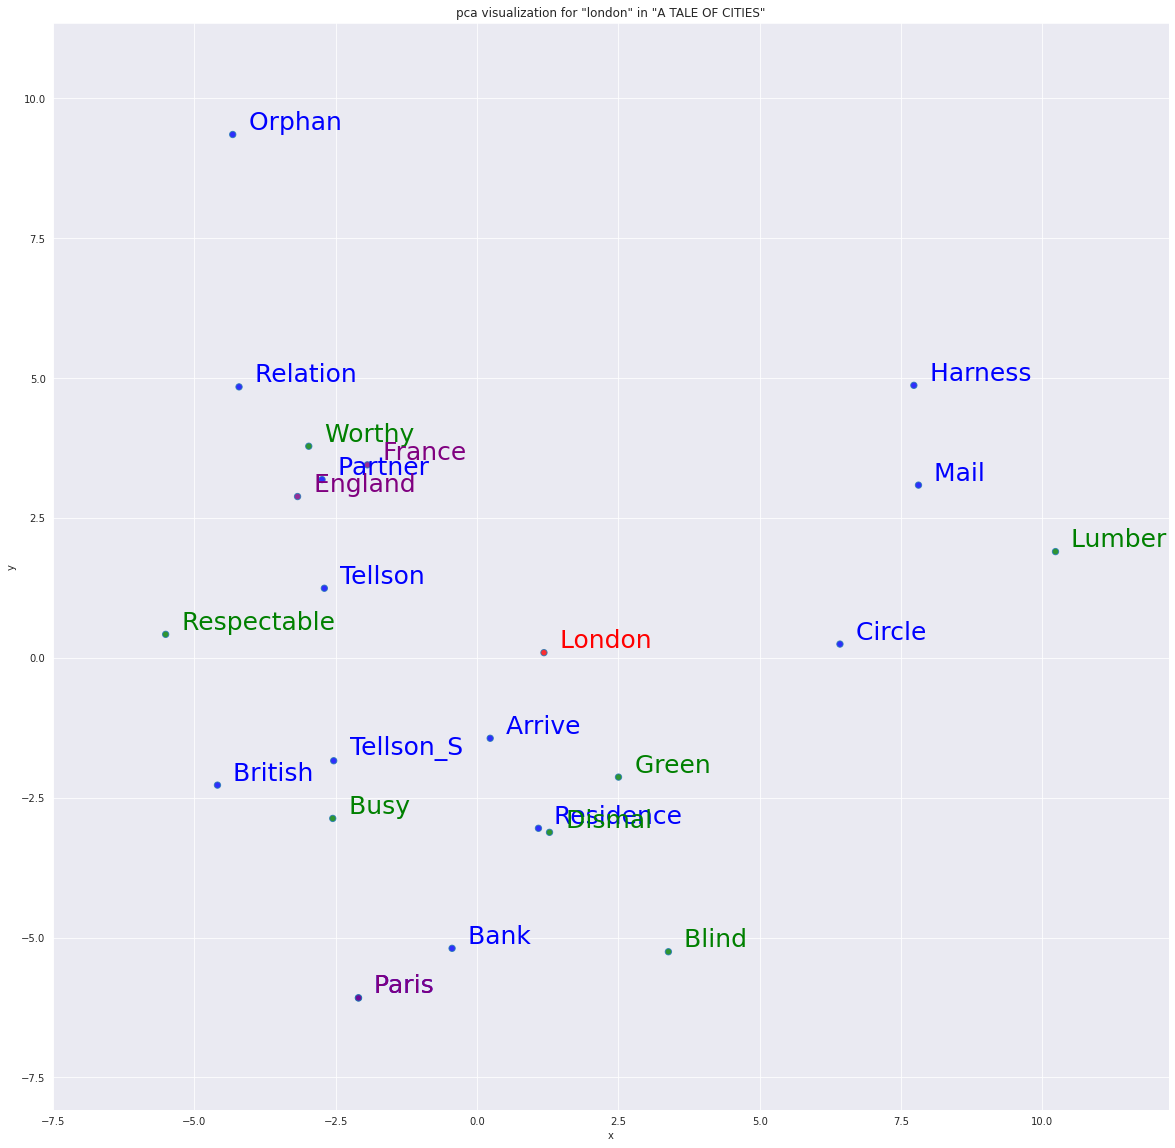

In [16]:
print("\n")
print("#"*60)
query = 'london'
results = location_sentiment_analysis(query=query, w2v_model=w2v_model, num_k=20, obj_threshold=0.5)
query, neighbor_words, used_neighbor_list, sentiment_score = results

print()
scatterplot(w2v_model, query, neighbor_words, used_neighbor_list, other_words_list=['paris', 'england', 'france'])



############################################################
Query:  paris
K-neigbor words:  ['journey', 'foresee', 'despatch', 'busy', 'london', 'day', 'travel', 'league', 'deal', 'country', 'beauvais', 'numerous', 'delay', 'shilling', 'overflow', 'keeper', 'fact', 'destroy', 'belong', 'bank']
K-neigbor distances:  [0.28941571712493896, 0.23128516972064972, 0.21946008503437042, 0.21834565699100494, 0.20906418561935425, 0.2040880173444748, 0.19717764854431152, 0.19540128111839294, 0.19440944492816925, 0.1826905906200409, 0.18261481821537018, 0.1803891658782959, 0.1795310229063034, 0.17806847393512726, 0.1756616234779358, 0.1713295578956604, 0.17122399806976318, 0.16953983902931213, 0.1694190353155136, 0.16906628012657166]

	target word: journey
		synset name	positive 	negative 	objective
		 journey.n.01 	 0.0 		 0.0 		 1.0
		 travel.v.02 	 0.0 		 0.0 		 1.0
		 travel.v.04 	 0.0 		 0.0 		 1.0
	 sentiment score of 'journey': 0.0

	target word: foresee
		synset name	positive 	negative 	

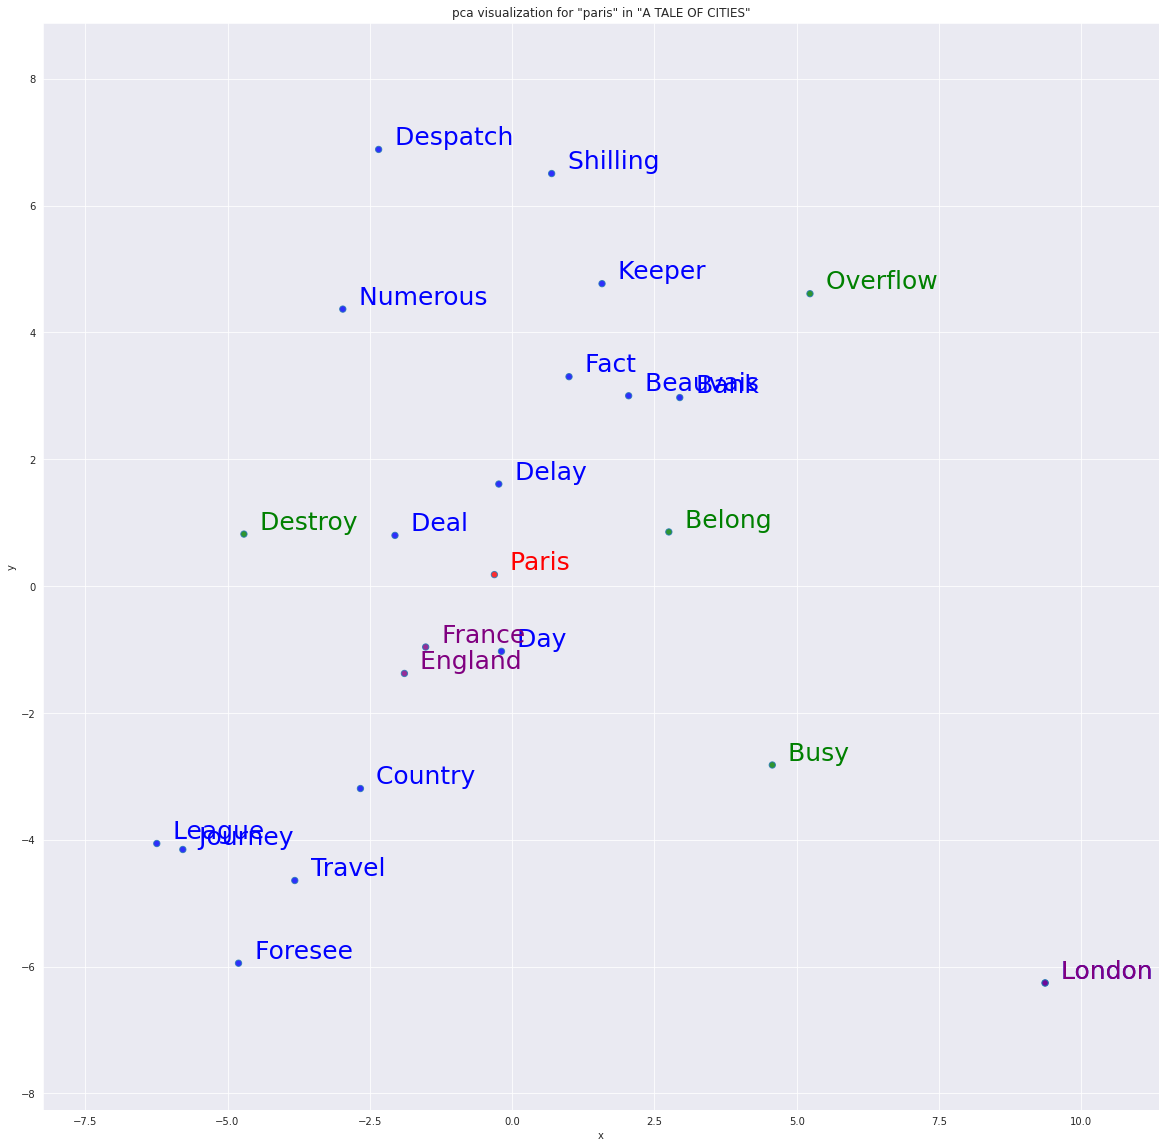

In [17]:
print("\n")
print("#"*60)
query = 'paris'
results = location_sentiment_analysis(query=query, w2v_model=w2v_model, num_k=20, obj_threshold=0.5)
query, neighbor_words, used_neighbor_list, sentiment_score = results

print()
scatterplot(w2v_model, query, neighbor_words, used_neighbor_list, other_words_list=['london', 'england', 'france'])




############################################################
Query:  london
K-neigbor words:  ['tellson', 'mail', 'partner', 'busy', 'tellson_s', 'green', 'arrive', 'blind', 'paris', 'worthy', 'harness', 'circle', 'british', 'lumber', 'relation', 'residence', 'orphan', 'respectable', 'bank', 'dismal']
K-neigbor distances:  [0.2995634973049164, 0.288918137550354, 0.24220725893974304, 0.2421613335609436, 0.23996825516223907, 0.23580901324748993, 0.23178686201572418, 0.2117442786693573, 0.20906418561935425, 0.200467050075531, 0.19884154200553894, 0.19682177901268005, 0.19656360149383545, 0.18794438242912292, 0.1869078129529953, 0.18644863367080688, 0.18561160564422607, 0.18511523306369781, 0.18460708856582642, 0.1792565882205963]

	target word: tellson
		synset name	positive 	negative 	objective
	 sentiment score of 'tellson': 0.0

	target word: mail
		synset name	positive 	negative 	objective
		 mail.n.01 	 0.0 		 0.0 		 1.0
		 mail.n.02 	 0.0 		 0.0 		 1.0
		 mail.n.03 	 0.0 		 0.0 		

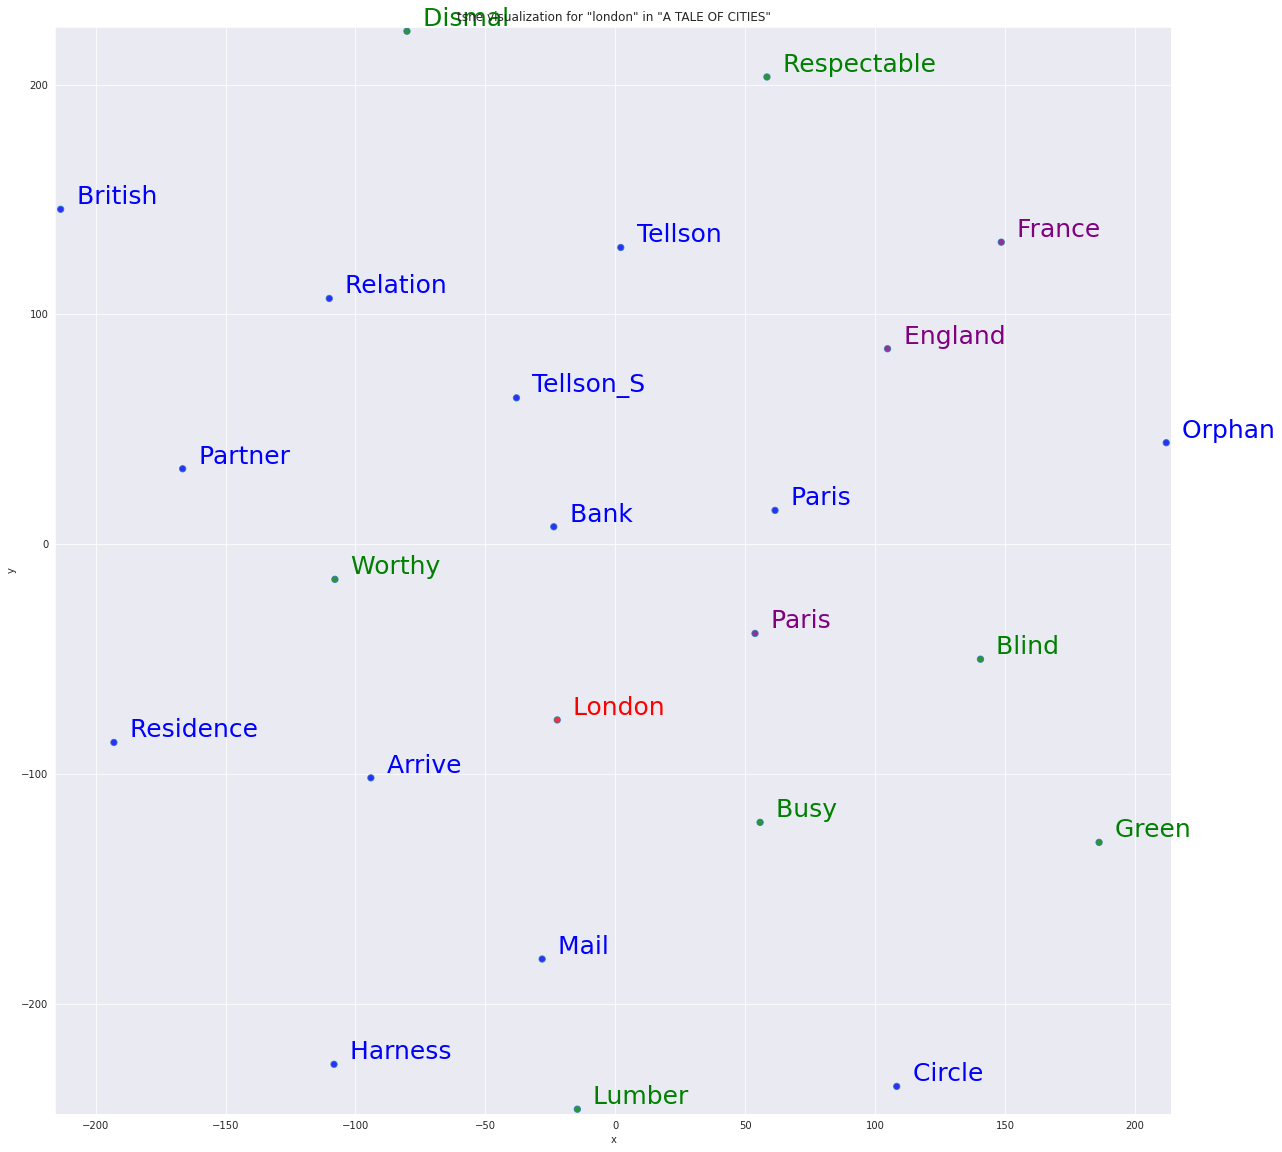

In [18]:
print("\n")
print("#"*60)
query = 'london'
results = location_sentiment_analysis(query=query, w2v_model=w2v_model, num_k=20, obj_threshold=0.5)
query, neighbor_words, used_neighbor_list, sentiment_score = results

print()
scatterplot(w2v_model, query, neighbor_words, used_neighbor_list, other_words_list=['paris', 'england', 'france'], method='tsne')



############################################################
Query:  paris
K-neigbor words:  ['journey', 'foresee', 'despatch', 'busy', 'london', 'day', 'travel', 'league', 'deal', 'country', 'beauvais', 'numerous', 'delay', 'shilling', 'overflow', 'keeper', 'fact', 'destroy', 'belong', 'bank']
K-neigbor distances:  [0.28941571712493896, 0.23128516972064972, 0.21946008503437042, 0.21834565699100494, 0.20906418561935425, 0.2040880173444748, 0.19717764854431152, 0.19540128111839294, 0.19440944492816925, 0.1826905906200409, 0.18261481821537018, 0.1803891658782959, 0.1795310229063034, 0.17806847393512726, 0.1756616234779358, 0.1713295578956604, 0.17122399806976318, 0.16953983902931213, 0.1694190353155136, 0.16906628012657166]

	target word: journey
		synset name	positive 	negative 	objective
		 journey.n.01 	 0.0 		 0.0 		 1.0
		 travel.v.02 	 0.0 		 0.0 		 1.0
		 travel.v.04 	 0.0 		 0.0 		 1.0
	 sentiment score of 'journey': 0.0

	target word: foresee
		synset name	positive 	negative 	

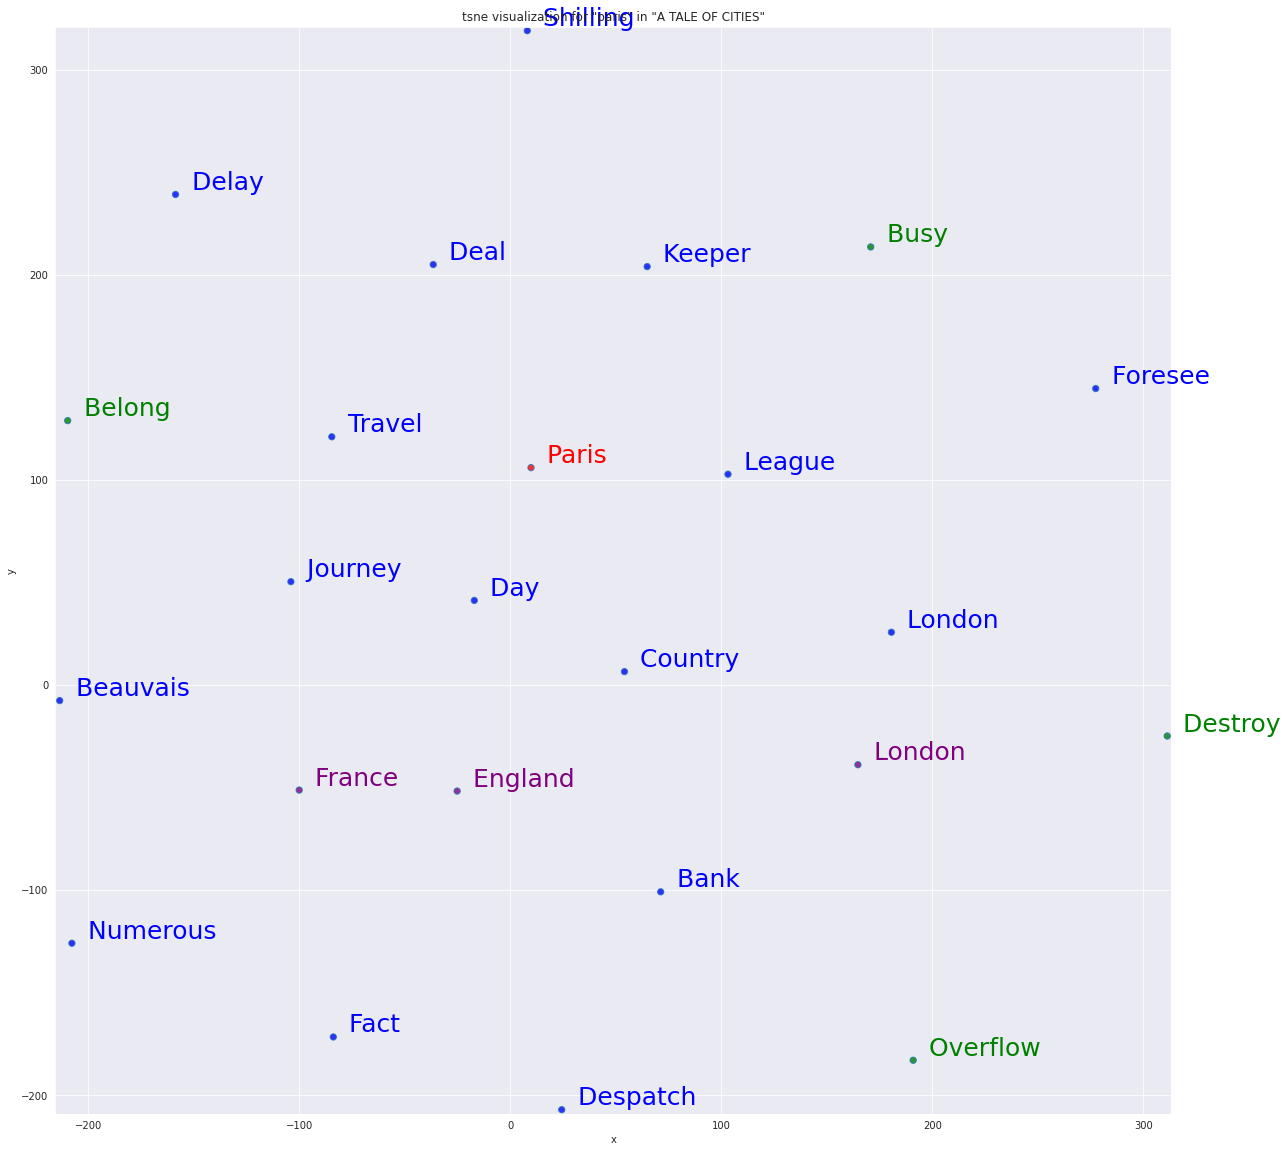

In [19]:
print("\n")
print("#"*60)
query = 'paris'
results = location_sentiment_analysis(query=query, w2v_model=w2v_model, num_k=20, obj_threshold=0.5)
query, neighbor_words, used_neighbor_list, sentiment_score = results

print()
scatterplot(w2v_model, query, neighbor_words, used_neighbor_list, other_words_list=['london', 'england', 'france'], method='tsne')